# Encoding Model (GLMs) for population activity as a function of sensory and behavioral variables

In [48]:
# importing modules and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io_utils import *
from plotting_utils import *
from analysis_utils import * 
from pathlib import Path
import pickle
import scipy


In [49]:
animals = ['29L','3095','3096','3097','30B','30L','30R2','4013','4014','4015','4016','91R2'] # list of all aniamls
days = ['d1_balbc','d2_balbc','d3_balbc','d4_balbc','d5_balbc','d6_balbc','d7_balbc','d8_balbc','d9_mCD1'] # list of all days
daysObs = ['d1_obs','d2_obs','d3_obs','d4_obsc','d5_obs','d6_obs','d7_obs','d8_obs','d9_obs'] # list of all days for observer group
animalsObs = ['29L','30R2'] # list of observer animals
sessions = ['t1','t2','t3'] # session in each day

In [50]:
# with open('../data/29L_d1_balbc_t1_zscored_features.pickle', 'rb') as handle: # from cup folder 020924
#     dict = pickle.load(handle)
# df = pd.DataFrame(dict)
# df.head()
z = pd.read_parquet('../data/29L_d1_balbc_t1_zscored_features.parquet')
z.head()

,resident tti2head,resident tti2trunk,resident tti2neck,resident tti2centroid,resident head2nose,resident trunk2head,resident forepaw left2head,resident forepaw right2head,resident forepaw left2trunk,resident forepaw right2trunk,...,resident2intruder nose-centroid mean across lags,resident2intruder nose-centroid median across lags,resident2intruder nose-centroid sum across lags,intruder2resident nose-centroid mean across lags,intruder2resident nose-centroid median across lags,intruder2resident nose-centroid sum across lags,intruder2resident nose-tti mean across lags,intruder2resident nose-tti median across lags,intruder2resident nose-tti sum across lags,pixel change
0,-0.772152,-0.655448,-1.130393,-0.097189,1.360581,-1.378523,-0.989778,2.040595,0.167322,1.853846,...,0.256217,0.997051,0.256217,-0.384007,0.164879,-0.384007,-1.012908,-0.549364,-1.012908,1.888377
1,-0.766932,-0.649833,-1.124174,-0.093004,1.358083,-1.372003,-0.984754,2.041990,0.156222,1.844537,...,0.257808,1.002044,0.257808,-0.382684,0.168854,-0.382684,-1.011720,-0.545818,-1.011720,1.909116
2,-0.756546,-0.638667,-1.111799,-0.084690,1.353078,-1.359033,-0.974688,2.044690,0.134239,1.826001,...,0.260978,1.011921,0.260978,-0.380049,0.176720,-0.380049,-1.009355,-0.538797,-1.009355,1.923927
3,-0.741099,-0.622070,-1.093393,-0.072356,1.345553,-1.339750,-0.959545,2.048513,0.101796,1.798395,...,0.265694,1.026467,0.265694,-0.376129,0.188308,-0.376129,-1.005837,-0.528449,-1.005837,1.932045
4,-0.720747,-0.600227,-1.069145,-0.056167,1.335495,-1.314358,-0.939283,2.053199,0.059511,1.761960,...,0.271914,1.045369,0.271914,-0.370960,0.203375,-0.370960,-1.001197,-0.514983,-1.001197,1.932794


In [51]:
animal = '29L'
df = load_and_wrangle(mouseId=animal, path=None, overwrite=False) # load csv for animal

In [52]:
featuresShortlist = ["proximity","resident centroid roc 500 ms", "intruder centroid roc 500 ms",'resident2intruder head-head', 'resident2intruder head-tti','resident2intruder head2head angle', 'resident2intruder head2tti angle', "intruder2resident head2centroid angle"]
featuresLonglist = ["proximity",'resident2intruder head-head', 'resident2intruder head-tti','resident2intruder head2head angle', 'resident2intruder head2tti angle', "intruder2resident head2centroid angle","resident centroid roc 500 ms", "intruder centroid roc 500 ms",
   "resident tti2head", "intruder tti2head", "resident tailbase2head angle", "intruder tailbase2head angle"] # potentially add more

In [53]:
regions = get_regions_dataframe(df) # get recorded regions from dataframe
lag_minus = 0
lag_plus = 10
print(regions)
variables_lags = {'aggr' : [lag_minus,lag_plus]}#, featuresShortlist[0]: [lag_minus,lag_plus]}

['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)', 'VMH (E)', 'VMH (I)', 'PAG (E)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 'PA (E)', 'PA (I)', 'NAc (DA)']


In [54]:
# def get_design_X_GLM_aggression(animal, variables_lags=variables_lags, path=None):
#     ''' 
#     function to prepare X design matrix (behavioral variables) for GLM

#     Parameters:
#     ----------
#     animal: str
#         animal ID
#     variables: list of str
#         behavioral variables to be include in the design matrix
#     timelags: list of [int,int]
#         both positive


#     Returns:
#     --------
#     X_all: numpy array
#         array of behavioral features in time for all days together
#     X: array of vectors
#         X[day] is an array of behavioral features in time given for a particular day
#     '''

#     # loading path on my laptop as default
#     path = Path("/Users/lencacuturela/Desktop/Research/github/Falkner_Multi-region_Aggression/data") if path is None else Path(path)

#     df = load_and_wrangle(mouseId=animal, path=path, overwrite=False)
#     regions = get_regions_dataframe(df)
#     days = np.unique(df['day'])
#     trials = np.unique(df['trial'])

#     X = np.empty((len(days)), dtype=object)
#     c = 0
#     for var in variables_lags:
#         # lags
#         lag_minus = abs(variables_lags[var][0]) # absolute value
#         lag_plus = variables_lags[var][1] # positive

#         for ind_day in range(0, len(days)): # day index

#             X_temp = np.empty((len(trials)), dtype=object)
#             for ind_trial in range(0,len(trials)): # trial index
                
#                 dftemp = df[df['day'] == days[ind_day]]
#                 dftemp = dftemp[dftemp['trial'] == trials[ind_trial]].reset_index()
#                 if (var == 'aggr'):
#                     stim = np.array(dftemp['supervised labels']) # aggression binary value
#                 else: 
#                     stim = np.array(dftemp['supervised labels']) # aggression binary value # just for testing concatenation
#                     # stim = np.load(f'../data_falkner/{animal}_{days[ind_day]}_{trials[ind_trial]}_featuresShortlist1.npy')[:,0]
#                 T = stim.shape[0]

#                 X_temp[ind_trial] = np.zeros((T, lag_minus + lag_plus))
#                 for t in range(T): 
#                     if (t < lag_minus):
#                         X_temp[ind_trial][t, lag_minus:lag_minus+lag_plus] = stim[t:t+lag_plus]
#                         X_temp[ind_trial][t, lag_minus-t:lag_minus] = stim[0:t]
#                     elif (t >= T - lag_plus):
#                         X_temp[ind_trial][t, 0:lag_minus] = stim[t-lag_minus:t]
#                         X_temp[ind_trial][t, lag_minus:lag_minus+ T - t] = stim[t:T]
#                     else:
#                         X_temp[ind_trial][t] = stim[t-lag_minus:t+lag_plus]
                        
#             if c==0: # first regressor    
#                 X[ind_day] = np.concatenate((X_temp), axis=0) # concatenate across trials within a day
#                 X[ind_day] = np.append(np.ones((X[ind_day].shape[0],1)), X[ind_day], axis=1) # add bias term as first column
#             else:
#                 X[ind_day] = np.concatenate([X[ind_day], np.concatenate(X_temp, axis=0)], axis=1)     
                        
#         c += 1
    
#     X_all = np.concatenate(X, axis=0) # concatenate all days together

#     return X_all, X

# X_all, X = get_design_X_GLM(animal, variables=variables_lags, path=None)

In [79]:
from astropy.stats import bayesian_blocks
def get_design_X_GLM_features(animal, features, Nbins=50, path=None):

    ''' 
    function to prepare X design matrix (behavioral variables) for GLM

    Parameters:
    ----------
    animal: str
        animal ID
    variables: list of str
        behavioral variables to be include in the design matrix
    timelags: list of [int,int]
        both positive


    Returns:
    --------
    X_all: numpy array
        array of behavioral features in time for all days together
    X: array of vectors
        X[day] is an array of behavioral features in time given for a particular day
    '''

    # loading path on my laptop as default
    path = Path("/Users/lencacuturela/Desktop/Research/github/Falkner_Multi-region_Aggression/data") if path is None else Path(path)

    df = load_and_wrangle(mouseId=animal, path=path, overwrite=False)
    regions = get_regions_dataframe(df)
    days = np.unique(df['day'])
    trials = np.unique(df['trial'])

    X = np.empty((len(days)), dtype=object)
    for ind_feature in range(len(features)):
        a = np.empty((len(days)*len(trials)), dtype=object) # all features across sessions to get optimal bin partition
        c = 0 # counting index
        for ind_day in range(0, len(days)): # day index
            for ind_trial in range(0,len(trials)): # trial index
                if (ind_day == 8):
                    other = 'mCD1'
                else:
                    other = 'balbc'
                df = pd.read_parquet(f'../data/29L_{days[ind_day]}_{other}_{trials[ind_trial]}_zscored_features.parquet')
                a[c] = np.array(df[features[ind_feature]])
                c += 1

        all = np.concatenate(a)
        # bin_edges = np.histogram_bin_edges(all, bins='fd') # optimal number of bins with fd method
        _, bin_edges = np.histogram(all, bins=Nbins)
        # print(bin_edges.shape)
        # plt.figure()
        # plt.title(features[ind_feature])
        # plt.hist(all, bins=bin_edges)
        # plt.show()
        
        c = 0
        for ind_day in range(0, len(days)): # day index
            X_temp = np.empty((len(trials)), dtype=object)
            for ind_trial in range(0,len(trials)): # trial index
                for ind_bin in range(bin_edges.shape[0]-1):
                    ind = np.argwhere(a[c] >=  bin_edges[ind_bin])
                    print(ind)
                    print(a[ind])
                    X_temp[ind_trial] = a[c]
                c += 1                
                # to bin regressor
                # X_temp[ind_trial] = np.zeros((T, bins))
                # print(array)

    #             X_temp[ind_trial] = np.zeros((T, lag_minus + lag_plus))
    #             for t in range(T): 
    #                 if (t < lag_minus):
    #                     X_temp[ind_trial][t, lag_minus:lag_minus+lag_plus] = stim[t:t+lag_plus]
    #                     X_temp[ind_trial][t, lag_minus-t:lag_minus] = stim[0:t]
    #                 elif (t >= T - lag_plus):
    #                     X_temp[ind_trial][t, 0:lag_minus] = stim[t-lag_minus:t]
    #                     X_temp[ind_trial][t, lag_minus:lag_minus+ T - t] = stim[t:T]
    #                 else:
    #                     X_temp[ind_trial][t] = stim[t-lag_minus:t+lag_plus]
                        
    #         if c==0: # first regressor    
    #             X[ind_day] = np.concatenate((X_temp), axis=0) # concatenate across trials within a day
    #             X[ind_day] = np.append(np.ones((X[ind_day].shape[0],1)), X[ind_day], axis=1) # add bias term as first column
    #         else:
    #             X[ind_day] = np.concatenate([X[ind_day], np.concatenate(X_temp, axis=0)], axis=1)     
                        
    #     c += 1
    
    # X_all = np.concatenate(X, axis=0) # concatenate all days together

    # return X_all, X
get_design_X_GLM_features(animal, features=featuresShortlist[0], Nbins=50, path=None)

KeyError: 'p'

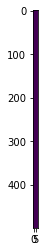

In [24]:
plt.imshow(X_all[1000:1500,1:])

In [57]:
def get_output_Y_GLM(animal, region, path=None):
    ''' 
    function to prepare vector output Y (calcium populationa activity for one specific region) for GLM

    Parameters:
    ----------
    animal: str
        animal ID
    region: str
        region name

    Returns:
    --------
    Y_all: numpy array
        vector of calcium activity of the given region for all sessions together
    Y: array of vectors
        Y[day] is a vector of calcium activity in the region given for a particular session
    '''
    # loading path on my laptop as default
    path = Path("/Users/lencacuturela/Desktop/Research/github/Falkner_Multi-region_Aggression/data") if path is None else Path(path)

    df = load_and_wrangle(mouseId=animal, path=path, overwrite=False)
    regions = get_regions_dataframe(df)
    days = np.unique(df['day'])
    trials = np.unique(df['trial'])

    if region not in regions:
        return np.nan, np.nan
    else:
        Y_all = np.array(df[region])
        Y = np.empty((len(days)), dtype=object)

        for ind_day in range(0, len(days)): # day index
            if (ind_day == 8):
                other = 'mCD1'
            else:
                other = 'balbc'
                
            Y_temp = np.empty((len(trials)), dtype=object)
            for ind_trial in range(0,len(trials)): # trial index
                dftemp = df[df['day'] == days[ind_day]]
                dftemp = dftemp[dftemp['trial'] == trials[ind_trial]]
                dftemp = dftemp[dftemp['other'] == other].reset_index()
                Y_temp[ind_trial] = np.array(dftemp[region])
                print(Y_temp[ind_trial].shape)
            Y[ind_day] = np.concatenate(Y_temp, axis=0)
        return Y_all, Y

Y_all, Y = get_output_Y_GLM(animal, 'VMH (E)', path=None)


(21023,)
(21135,)
(21098,)
(21072,)
(21414,)
(20542,)
(21189,)
(21088,)
(22768,)
(20910,)
(20236,)
(19945,)
(20503,)
(20677,)
(20461,)
(19983,)
(20830,)
(20853,)
(21002,)
(22160,)
(20807,)
(21059,)
(21187,)
(22930,)
(9577,)
(9509,)
(9488,)


In [10]:
def lsr_mse(X_true, Y_true, W_map):
    return np.linalg.norm(X_true @ W_map - Y_true) ** 2 / Y_true.shape[0]

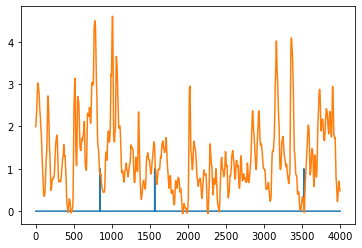

In [11]:
plt.figure()
plt.plot(X_all[4000:8000,1])
plt.plot(Y_all[4000:8000])

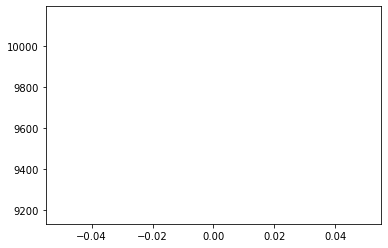

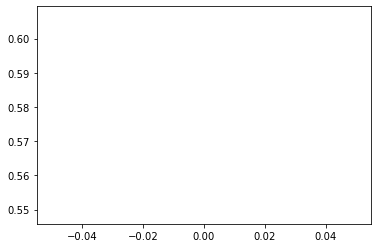

In [12]:
# compute STA
Y_all = Y_all - np.mean(Y_all)
# plt.plot(X_all.T @ Y_all)
sta = X_all[:,1:].T @ Y_all
plt.plot(sta)
plt.show()
Wmap = np.linalg.solve(X_all.T @ X_all, X_all.T @ Y_all)
plt.plot(Wmap[1:])

In [13]:
# Linear Gaussian GLM model 
def solution_GLM_linear_Gaussian(X, Y, lamda):
    return np.linalg.solve(X.T @ X + lamda * np.diag(np.ones((X.shape[1]))), X.T @ Y) 
w_hat = solution_GLM_linear_Gaussian(X_all, Y_all, 1/2)
# plt.scatter(range(lag_minus + lag_plus ), w_hat[1:])
# plt.xticks(range(lag_minus + lag_plus),range(-lag_minus,lag_plus))
# plt.xlabel('aggression filter')
# plt.title('all days together')
# plt.show()

In [19]:
from sklearn.model_selection import train_test_split
lamda_values = [0.1,1,10,100,1000]#,3000,10000,30000]
lag_values = [[-1,1],[-10,10],[-100,100],[-1000,1000]]#,[-3000,3000]]
W_map = np.empty((len(regions), len(lamda_values), len(lag_values)), dtype=object)
train_mse = np.zeros((len(regions), len(lamda_values), len(lag_values)))
test_mse = np.zeros((len(regions), len(lamda_values), len(lag_values)))

for reg in [7,12,19]:#[4,7,10,12,-1]:#range(len(regions)):
    print(regions[reg])
    for ind1 in range(len(lamda_values)):
        print(ind1)
        lamda = lamda_values[ind1]
        for ind2 in range(len(lag_values)):
            [lag_minus, lag_plus] = lag_values[ind2]
            variables={'aggr' : [lag_minus, lag_plus]}
            X_all, X = get_design_X_GLM(animal, variables=variables, path=None)
            Y_all, Y = get_output_Y_GLM(animal, regions[reg], path=None)
            D = X_all.shape[1]

            # Split data
            X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)
            
            # Fit to train data
            W_map[reg, ind1, ind2] = solution_GLM_linear_Gaussian(X_train, Y_train, lamda)

            # MSE
            train_mse[reg, ind1,ind2] = lsr_mse(X_train, Y_train, W_map[reg,ind1,ind2])
            test_mse[reg, ind1,ind2] = lsr_mse(X_test, Y_test, W_map[reg,ind1,ind2])

            # plt.scatter(-lag_minus-1, W_map[ind1, ind2][0])
            # plt.xticks([-lag_minus-1] + list(range(-lag_minus, lag_plus,5)), ['bias'] + list(range(-lag_minus, lag_plus, 5)))
            # plt.plot(range(-lag_minus, lag_plus), W_map[ind1, ind2][1:])
            # plt.ylim(-0.5,2.5)
            # plt.xlabel('aggression filter')
            # plt.title(f'lambda = {lamda}, ' + f'lag is ({lag_minus},{lag_plus})')
            # plt.show()


AH (I)
0
1
2
3
4
PAG (E)
0
1
2
3
4
NAc (DA)
0
1
2
3
4


0.3907588570733307


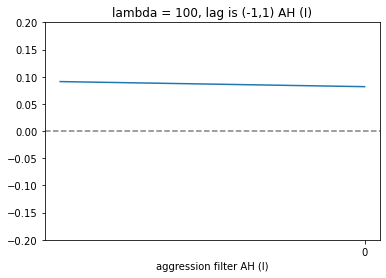

0.39047880796629464


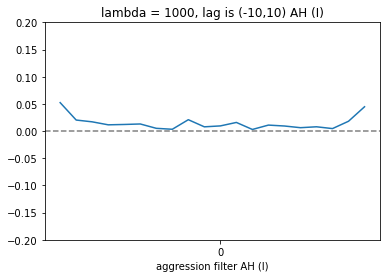

0.3897795389858227


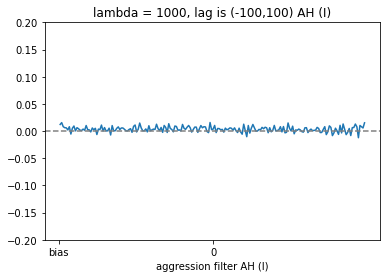

0.3900005743408813


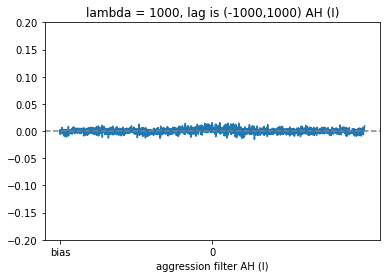

0.22985244963764115


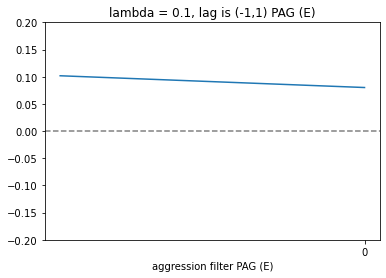

0.22955422328393976


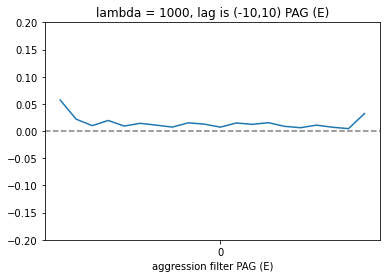

0.22939027922855387


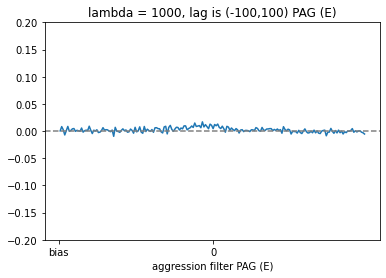

0.2297410472612686


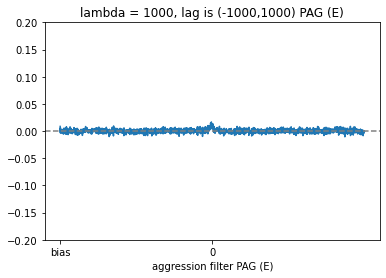

0.40398772385777015


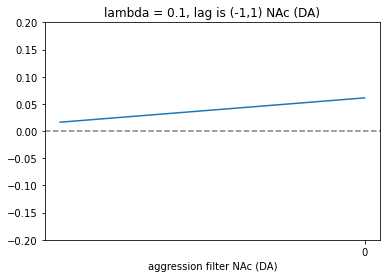

0.4039279789181844


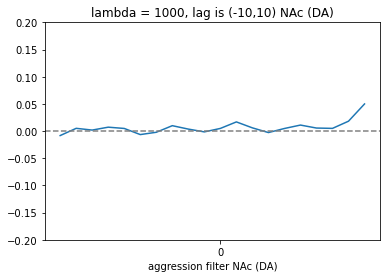

0.4031034436008867


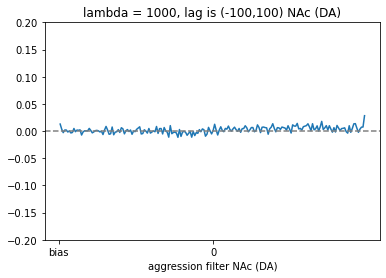

0.402947435923204


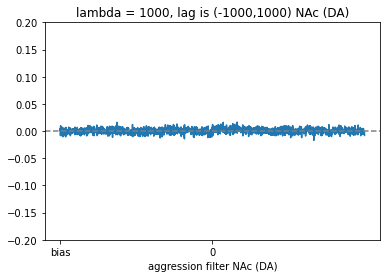

In [32]:
best_lamda = np.zeros((len(regions), len(lag_values)), dtype=int)
for reg in [7,12,19]:#[4,7,10,12,-1]:#range(len(regions)):
    for ind2 in range(len(lag_values)):
        [lag_minus, lag_plus] = lag_values[ind2]
        best_lamda[reg, ind2] = np.argmin(test_mse[reg,:,ind2])
        # plt.figure()
        # plt.title(f'lag is [{lag_minus},{lag_plus}] ' + str(regions[reg]))
        # plt.plot(np.log10(lamda_values), train_mse[reg, :,ind2], '-o', label=f'train')
        # plt.plot(np.log10(lamda_values), test_mse[reg, :,ind2], '-o', label=f'test')
        # plt.ylabel('MSE')
        # plt.xlabel('log10(lamda)')
        # # plt.ylim(2.05,2.25)
        # plt.legend()
        # plt.show()

        print(test_mse[reg,best_lamda[reg, ind2],ind2])
        plt.figure()
        # plt.scatter(lag_minus-1, W_map[reg, best_lamda[reg, ind2], ind2][0])
        #plt.xticks([-lag_minus-1] + list(range(-lag_minus, lag_plus, 10)), ['bias'] + list(range(-lag_minus, lag_plus, 10)))
        plt.xticks([lag_minus-1, 0], ['bias', 0])
        plt.plot(range(lag_minus, lag_plus), W_map[reg, best_lamda[reg, ind2], ind2][1:])
        plt.ylim(-0.2,0.2)
        plt.axhline(0, color='gray',ls='dashed')
        plt.xlabel('aggression filter '+ str(regions[reg]))
        plt.title(f'lambda = {lamda_values[best_lamda[reg, ind2]]}, ' + f'lag is ({lag_minus},{lag_plus}) ' + str(regions[reg]))
        plt.show()



In [18]:
from sklearn.model_selection import train_test_split
lamda_values = [0.1,1,10,100,1000] #,3000,10000,30000]
lag_values = [[-1,1],[-3,3],[-10,10],[-30,30],[-100,100],[-300,300],[-1000,1000]] #,[-3000,3000]]
W_map = np.empty((len(lamda_values), len(lag_values)), dtype=object)
train_mse = np.zeros((len(lamda_values), len(lag_values)))
test_mse = np.zeros((len(lamda_values), len(lag_values)))

for ind1 in range(len(lamda_values)):
    lamda = lamda_values[ind1]
    for ind2 in range(len(lag_values)):
        [lag_minus, lag_plus] = lag_values[ind2]
        variables={'aggr' : [lag_minus, lag_plus]}
        X_all, X = get_design_X_GLM(animal, variables=variables, path=None)
        Y_all, Y = get_output_Y_GLM(animal, 'VMH (E)', path=None)
        D = X_all.shape[1]
            
        # Split data
        X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)
            
        # Fit to train data
        W_map[ind1, ind2] = solution_GLM_linear_Gaussian(X_train, Y_train, lamda)

        # MSE
        train_mse[ind1,ind2] = lsr_mse(X_train, Y_train, W_map[ind1,ind2])
        test_mse[ind1,ind2] = lsr_mse(X_test, Y_test, W_map[ind1,ind2])

            # plt.scatter(-lag_minus-1, W_map[ind1, ind2][0])
            # plt.xticks([-lag_minus-1] + list(range(-lag_minus, lag_plus,5)), ['bias'] + list(range(-lag_minus, lag_plus, 5)))
            # plt.plot(range(-lag_minus, lag_plus), W_map[ind1, ind2][1:])
            # plt.ylim(-0.5,2.5)
            # plt.xlabel('aggression filter')
            # plt.title(f'lambda = {lamda}, ' + f'lag is ({lag_minus},{lag_plus})')
            # plt.show()

0


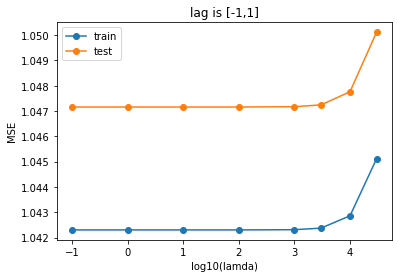

0


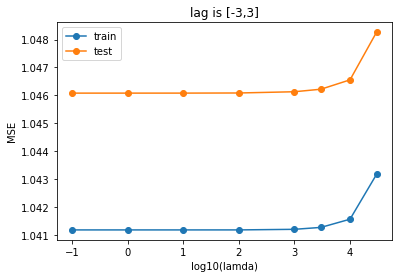

0


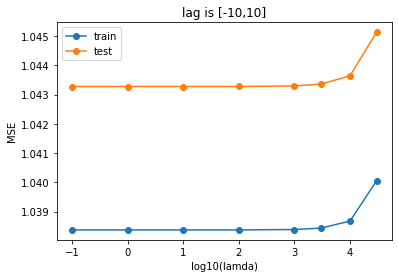

5


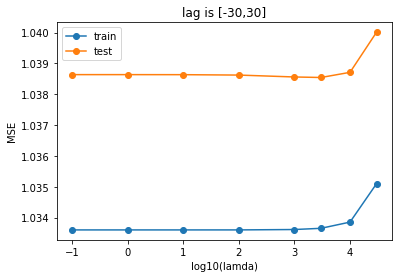

5


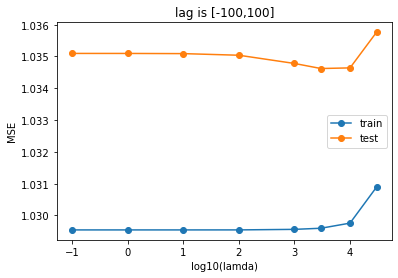

6


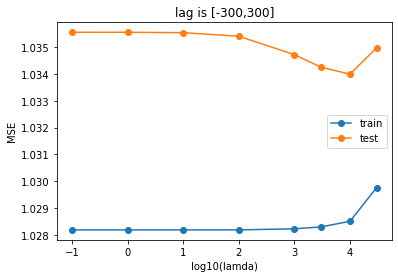

6


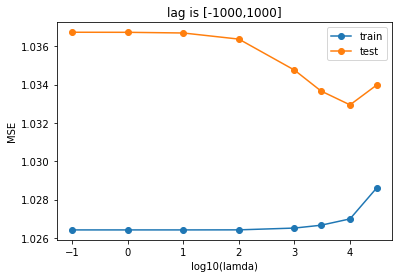

In [145]:
best_lamda = np.zeros((len(lag_values)), dtype=int)
for ind2 in range(len(lag_values)):
    [lag_minus, lag_plus] = lag_values[ind2]
    best_lamda[ind2] = np.argmin(test_mse[:,ind2])
    print(best_lamda[ind2])
    plt.title(f'lag is [{lag_minus},{lag_plus}]')
    plt.plot(np.log10(lamda_values), train_mse[:,ind2], '-o', label=f'train')
    plt.plot(np.log10(lamda_values), test_mse[:,ind2], '-o', label=f'test')
    plt.ylabel('MSE')
    plt.xlabel('log10(lamda)')
    # plt.ylim(2.05,2.25)
    plt.legend()
    plt.show()


1.047158365257469


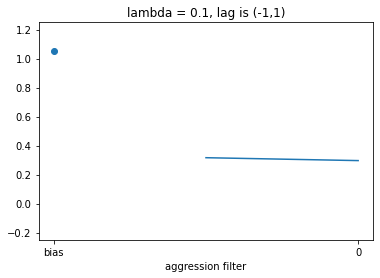

1.046082326335636


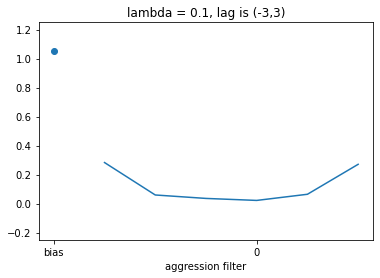

1.0432737243370493


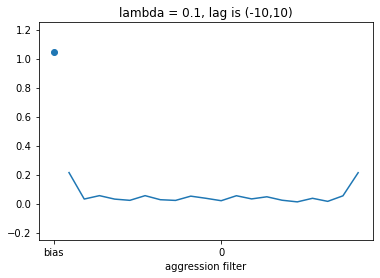

1.0385414656963423


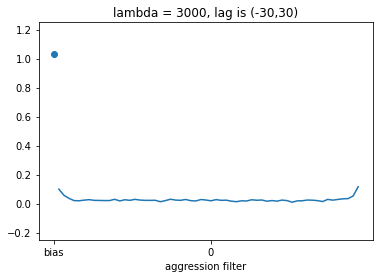

1.0346214545368755


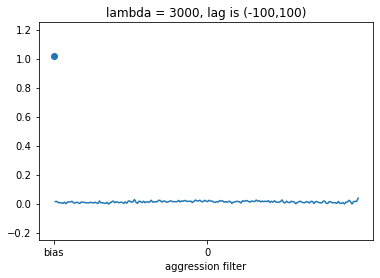

1.0339916127729538


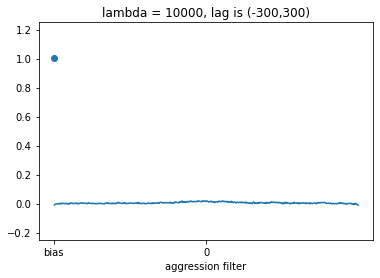

1.032943966306428


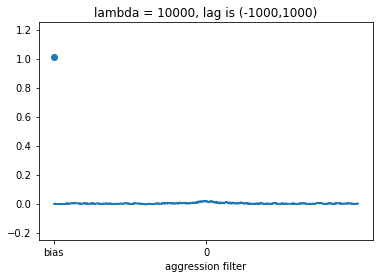

In [153]:
# plt.figure()
for ind2 in range(len(lag_values)):
    [lag_minus, lag_plus] = lag_values[ind2]
    # plt.scatter(np.log10(lag_plus), test_mse[best_lamda[ind2],ind2], label=f'[{lag_minus},{lag_plus}]')
    print(test_mse[best_lamda[ind2],ind2])

    plt.scatter(lag_minus-1, W_map[best_lamda[ind2], ind2][0])
    #plt.xticks([-lag_minus-1] + list(range(-lag_minus, lag_plus, 10)), ['bias'] + list(range(-lag_minus, lag_plus, 10)))
    plt.xticks([lag_minus-1, 0], ['bias', 0])
    plt.plot(range(lag_minus, lag_plus), W_map[best_lamda[ind2], ind2][1:])
    plt.ylim(-0.25,1.25)
    plt.xlabel('aggression filter')
    plt.title(f'lambda = {lamda_values[best_lamda[ind2]]}, ' + f'lag is ({lag_minus},{lag_plus})')
    plt.show()

# plt.legend()
# plt.show()

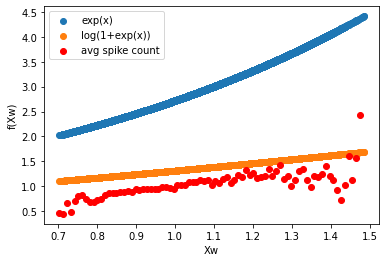

In [33]:
w_MLE = solution_GLM_linear_Gaussian(X_all, Y_all, lamda=0.1)
N = 80
h = np.histogram(X_all @ w_MLE, bins=N)
y_avg = np.zeros((N))
for bin in range(0,N):
  ind_higher = np.argwhere(X_all @ w_MLE >= h[1][bin]).flatten()
  ind_lower = np.argwhere(X_all @ w_MLE < h[1][bin+1]).flatten()
  ind_bin = list(set(ind_lower).intersection(set(ind_higher)))
  y_avg[bin] = Y_all[ind_bin].sum()/len(ind_bin)
plt.scatter(X_all @ w_MLE, np.exp(X_all @ w_MLE), label='exp(x)')
plt.scatter(X_all @ w_MLE, np.log(1+np.exp(X_all @ w_MLE)), label='log(1+exp(x))')
plt.scatter(h[1][:-1], y_avg, color='red', label='avg spike count')
plt.xlabel('Xw')
plt.ylabel('f(Xw)')
plt.legend()
plt.show()


In [64]:
# for [lag_minus,lag_plus] in [[0,1],[0,3],[0,10],[0,30],[0,100],[0,300]]:
#     variables={'aggr' : [lag_minus,lag_plus]}
#     X_all, X = get_design_X_GLM(animal, variables=variables, path=None)
#     Y_all, Y = get_output_Y_GLM(animal, 'VMH (E)', path=None)
#     w_hat = solution_GLM_linear_Gaussian(X_all, Y_all)
#     print("Intercept:", w_hat[0])
#     plt.scatter(range(-lag_minus, lag_plus ), w_hat[1:])
#     plt.xlabel('aggression filter')
#     plt.title('all days together')
#     plt.ylim(-0.5,2.5)
#     plt.show()


### Soft-plus Gaussian GLM

[0.62245273 0.78907392]


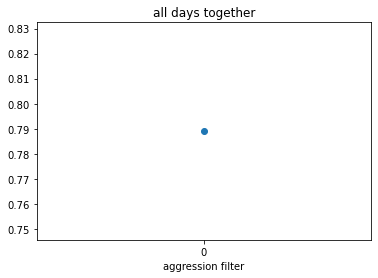

In [79]:
# Linear Gaussian GLM model 
def neglog_GLM_soft_plus_Gaussian(w, sigma, X, Y):
    f_X = np.log(1+np.exp(X @ w))
    negLl = X.shape[0]/2 * np.log(2*np.pi*sigma**2) + 1/(2*sigma**2) * np.linalg.norm(f_X-Y) ** 2
    return negLl
w_hat = scipy.optimize.minimize(neglog_GLM_soft_plus_Gaussian, w_MLE, args=(1, X_all, Y_all))['x']
print(w_hat)
plt.scatter(range(lag_minus + lag_plus ), w_hat[1:])
plt.xticks(range(lag_minus + lag_plus),range(-lag_minus,lag_plus))
plt.xlabel('aggression filter')
plt.title('all days together')
plt.show()

In [84]:
def soft_plus_Gaussian_mse(X_true, Y_true, W_map):
    return np.linalg.norm(np.log(1+np.exp(X_true @ W_map)) - Y_true) ** 2 / Y_true.shape[0]

1.0432880120135652


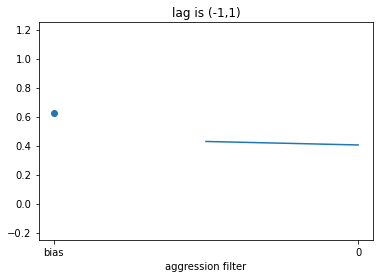

1.0422365263352562


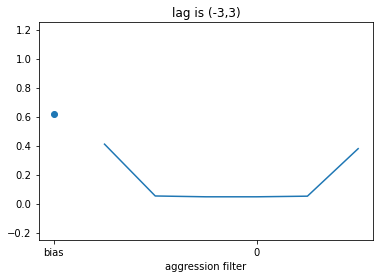

1.03959578315108


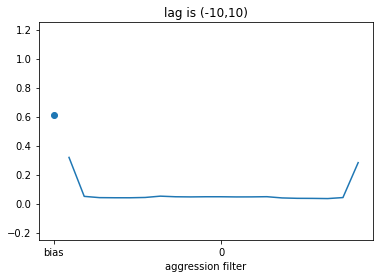

1.035066382207613


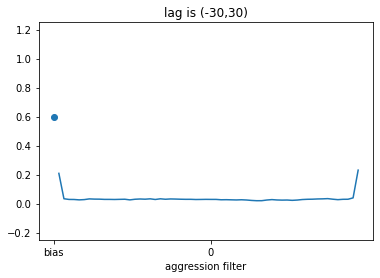

1.031153538106069


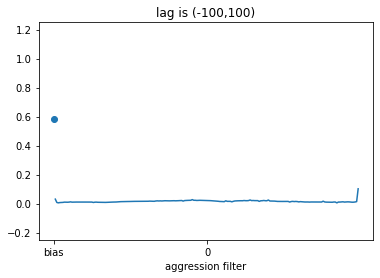

KeyboardInterrupt: 

In [90]:
from sklearn.model_selection import train_test_split

# lamda_values = [0.1,1,10,100]#,1000]
lag_values = [[-1,1],[-3,3],[-10,10],[-30,30],[-100,100],[-300,300],[-1000,1000]]
W_map = np.empty((len(lag_values)), dtype=object)
W_hat = np.empty((len(lag_values)), dtype=object)
train_mse = np.zeros((len(lag_values)))
test_mse = np.zeros((len(lag_values)))
                    

for ind2 in range(len(lag_values)):
    [lag_minus, lag_plus] = lag_values[ind2]
    variables={'aggr' : [lag_minus, lag_plus]}
    X_all, X = get_design_X_GLM(animal, variables=variables, path=None)
    Y_all, Y = get_output_Y_GLM(animal, 'VMH (E)', path=None)
    D = X_all.shape[1]

    # Fit to train data
    W_hat[ind2] = scipy.optimize.minimize(neglog_GLM_soft_plus_Gaussian, np.ones((X_all.shape[1]))/X_all.shape[1], args=(1, X_all, Y_all))['x']

    # MSE
    train_mse[ind2] = soft_plus_Gaussian_mse(X_all, Y_all, W_hat[ind2])
    # test_mse[ind2] = soft_plus_Gaussian_mse(X_all, Y_all, W_hat[ind2])

    print(train_mse[ind2])
    # print(test_mse[ind2])

    plt.scatter(lag_minus-1, W_hat[ind2][0])
    #plt.xticks([-lag_minus-1] + list(range(-lag_minus, lag_plus, 10)), ['bias'] + list(range(-lag_minus, lag_plus, 10)))
    plt.xticks([lag_minus-1, 0], ['bias', 0])
    plt.plot(range(lag_minus, lag_plus), W_hat[ind2][1:])
    plt.ylim(-0.25,1.25)
    plt.xlabel('aggression filter')
    plt.title(f'lag is ({lag_minus},{lag_plus})')
    plt.show()
